# Bayesian Linear Mixed-Effects Regression
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. Quick ANOVA example
2. Introduction to mixed-effects models
3. Introduction to Bayesian models
4. Fit and visualize a Bayesian mixed-effects regression to our data


# New libraries to install

You're going to need new Bayesian modeling and plotting libraries, so run these lines at your Anaconda Prompt/Terminal:

```bash
conda install -c conda-forge arviz
conda install -c conda-forge bambi
pip install scikit-misc
```
If the conda installations are taking too long, you can try to use `pip` to install all three.

In [19]:
%matplotlib inline

In [2]:
import sys
print(sys.executable)

/home/per/anaconda3/envs/smiledev/bin/python


In [2]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os
import arviz as az
import bambi as bmb
import statsmodels.formula.api as smf
import statsmodels.api as sm

from smile.log import log2dl

from ci_within import ci_within

## Custom SLOG loading function

In [3]:
# custom function to load slogs
def load_all_subj_logs(data_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.splitext(os.path.split(filepath)[1])[0].split('_')[-1]
             for filepath in glob(os.path.join(data_dir, log_file + '*.slog'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(data_dir, log_file+'_'+subj+'.slog')
        #print(log_path)

        # load the data
        try:
            all_dat.extend(log2dl(log_path, subj=subj))
        except:
            pass

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [4]:
# load the data from each task
data_dir = 'refresh_dat'
df_s = load_all_subj_logs(data_dir, 'log_refresh_study')
df_t = load_all_subj_logs(data_dir, 'log_refresh_test')
df_t.head()

resp_map_target resp_map_lure  block_num  trial_num  stim_on_time  \
0               J             F          0          0    141.686912   
1               J             F          0          1    145.325594   
2               J             F          0          2    147.322170   
3               J             F          0          3    149.190018   
4               J             F          0          4    151.307007   

   stim_on_error resp  resp_time_time  resp_time_error        rt  ...  \
0            0.0    J      144.111953         0.000479  2.425040  ...   
1            0.0    F      146.409344         0.000517  1.083750  ...   
2            0.0    F      148.306278         0.000450  0.984108  ...   
3            0.0    F      150.066530         0.002967  0.876512  ...   
4            0.0    F      152.004527         0.000440  0.697521  ...   

           arousal_sd      dominance_mean        dominance_sd word_frequency  \
0                2.71  3.9300000000000002                2.29             38   
1  2.6299999999999999  5.7999999999999998  2.1600000000000001             13   
2  2.3399999999999999                3.98  1.8999999999999999              3   
3  2.5899999999999999  6.4000000000000004                2.29             37   
4  2.4900000000000002  4.6799999999999997  1.8500000000000001             37   

  valence     cond pres_num    type  subj log_num  
0     neg   repeat        1  target  s000       0  
1     pos   repeat        1    lure  s000       0  
2     neg  refresh        1    lure  s000       0  
3     pos  refresh        1    lure  s000       0  
4     neu     once        1    lure  s000       0  

[5 rows x 27 columns]

## Some data clean-up

In [5]:
# add in log_rt columns
df_t['log_rt'] = np.log(df_t['rt'])

# must make correct an int
df_t['correct'] = df_t['correct'].astype(int)

# add in a column for whether they made an 'old' response
df_t['old_resp'] = (df_t['resp_map_target'] == df_t['resp']).astype(int)

# process some of the valence info
df_t['valence_mean'] = df_t['valence_mean'].astype(float)
df_t['arousal_mean'] = df_t['arousal_mean'].astype(float)
df_t['dominance_mean'] = df_t['dominance_mean'].astype(float)
df_t['abs_valence'] = np.abs(df_t['valence_mean'] - 5.0)
df_t['abs_arousal'] = np.abs(df_t['arousal_mean'] - 5.0)

# Word Recognition

Primary question: Is there an effect of valence (potentially interacting with condition) on recognition accuracy?

In [7]:
# get the error corrected by condition and whether they answered correctly
res = ci_within(df_t,  
                indexvar='subj',       # column that identifies a subject
                withinvars=['cond', 'type', 'valence'],     # list of columns for grouping within subject
                measvar='correct')        # dependent variable averaging over
res = res.reset_index()
res

cond    type valence      mean       std       sem        ci  len
0      once    lure     neg  0.923611  0.274426  0.016171  0.031828  288
1      once    lure     neu  0.934028  0.260725  0.015363  0.030239  288
2      once    lure     pos  0.920139  0.280461  0.016526  0.032528  288
3      once  target     neg  0.812500  0.389402  0.022946  0.045163  288
4      once  target     neu  0.791667  0.395323  0.023295  0.045850  288
5      once  target     pos  0.753472  0.422017  0.024868  0.048946  288
6   refresh    lure     neg  0.923611  0.276657  0.016302  0.032087  288
7   refresh    lure     neu  0.934028  0.263268  0.015513  0.030534  288
8   refresh    lure     pos  0.895833  0.315283  0.018578  0.036567  288
9   refresh  target     neg  0.850694  0.346662  0.020427  0.040206  288
10  refresh  target     neu  0.795139  0.389433  0.022948  0.045167  288
11  refresh  target     pos  0.763889  0.425829  0.025092  0.049388  288
12   repeat    lure     neg  0.930556  0.266831  0.015723  0.030947  288
13   repeat    lure     neu  0.951389  0.226459  0.013344  0.026265  288
14   repeat    lure     pos  0.937500  0.259475  0.015290  0.030094  288
15   repeat  target     neg  0.888889  0.308179  0.018160  0.035743  288
16   repeat  target     neu  0.847222  0.346971  0.020445  0.040242  288
17   repeat  target     pos  0.819444  0.375726  0.022140  0.043577  288

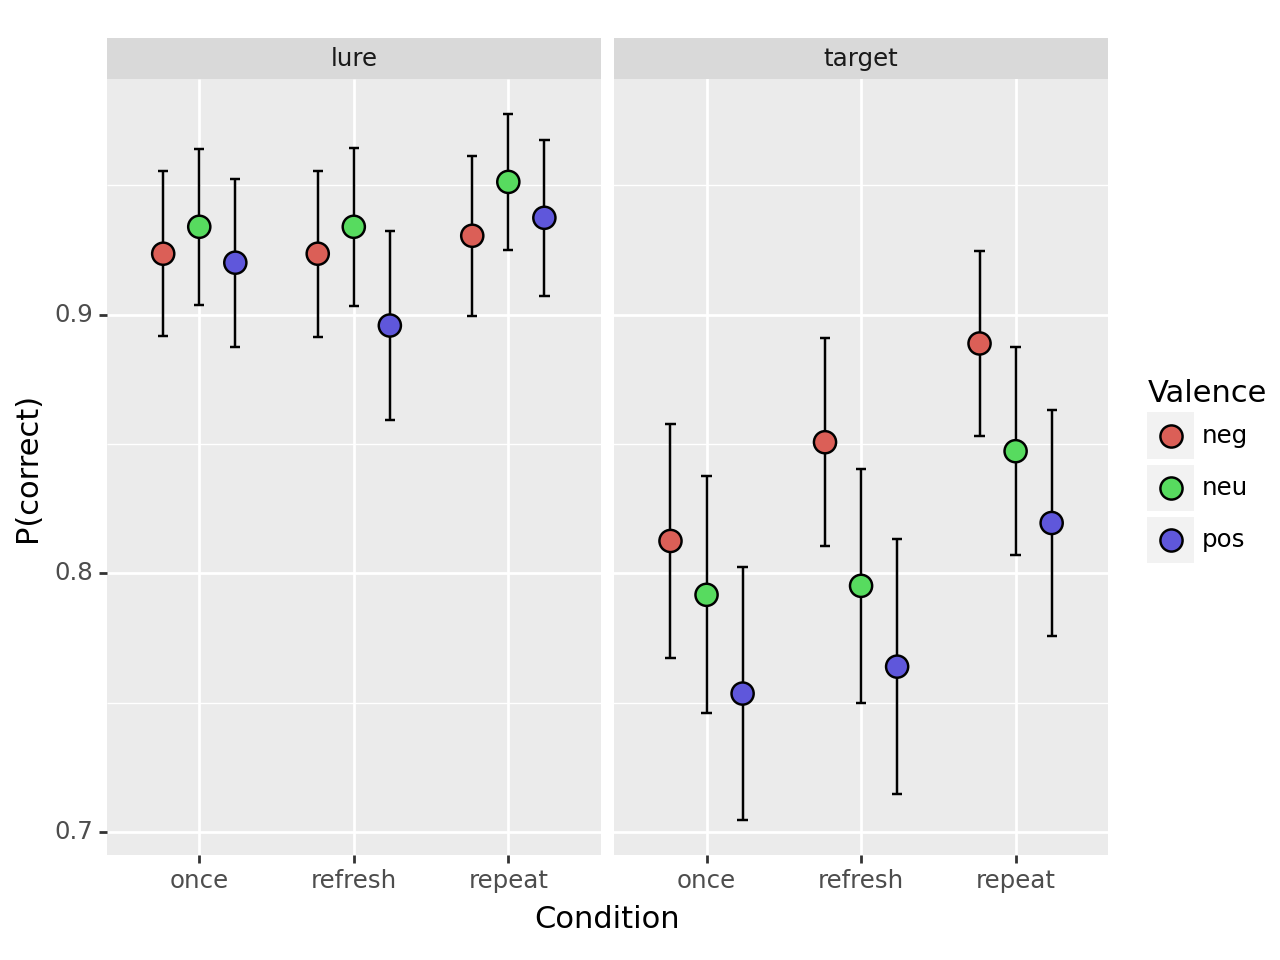

<Figure Size: (640 x 480)>

In [8]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.7))
     + pn.geom_point(position=pn.position_dodge(.7), size=4)
     + pn.facet_wrap('~type')
     + pn.labs(x="Condition", y = "P(correct)", fill='Valence')
    )
p

## Testing for significance

Using a standard linear model, we must average performance within subject


In [9]:
# use the agg method to get the means
perf = df_t.groupby(['subj', 'cond', 'valence', 'type'])['correct'].mean()
perf = perf.reset_index()
perf

subj    cond valence    type   correct
0    s000    once     neg    lure  0.916667
1    s000    once     neg  target  0.750000
2    s000    once     neu    lure  0.916667
3    s000    once     neu  target  0.583333
4    s000    once     pos    lure  1.000000
..    ...     ...     ...     ...       ...
427  s023  repeat     neg  target  0.833333
428  s023  repeat     neu    lure  0.916667
429  s023  repeat     neu  target  1.000000
430  s023  repeat     pos    lure  1.000000
431  s023  repeat     pos  target  0.750000

[432 rows x 5 columns]

In [10]:
# build a linear regression of the full model
m0 = smf.ols("correct ~ cond * valence * type", perf).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     5.813
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           5.64e-12
Time:                        00:40:46   Log-Likelihood:                 259.52
No. Observations:                 432   AIC:                            -483.0
Df Residuals:                     414   BIC:                            -409.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.9236      0.028     33.380      0.000       0.869       0.978
cond[T.refresh]                               -2.566e-16      0.039  -6.56e-15      1.000      -0.077       0.077
cond[T.repeat]                                    0.0069      0.039      0.177      0.859      -0.070       0.084
valence[T.neu]                                    0.0104      0.039      0.266      0.790      -0.067       0.087
valence[T.pos]                                   -0.0035      0.039     -0.089      0.929      -0.080       0.073
type[T.target]                                   -0.1111      0.039     -2.839      0.005      -0.188      -0.034
cond[T.refresh]:valence[T.neu]                 5.556e-17      0.055      1e-15      1.000      -0.109       0.109
cond[T.repeat]:valence[T.neu]                     0.0104      0.055      0.188      0.851      -0.098       0.119
cond[T.refresh]:valence[T.pos]                   -0.0243      0.055     -0.439      0.661      -0.133       0.084
cond[T.repeat]:valence[T.pos]                     0.0104      0.055      0.188      0.851      -0.098       0.119
cond[T.refresh]:type[T.target]                    0.0382      0.055      0.690      0.490      -0.071       0.147
cond[T.repeat]:type[T.target]                     0.0694      0.055      1.255      0.210      -0.039       0.178
valence[T.neu]:type[T.target]                    -0.0313      0.055     -0.565      0.573      -0.140       0.078
valence[T.pos]:type[T.target]                    -0.0556      0.055     -1.004      0.316      -0.164       0.053
cond[T.refresh]:valence[T.neu]:type[T.target]    -0.0347      0.078     -0.444      0.658      -0.189       0.119
cond[T.repeat]:valence[T.neu]:type[T.target]     -0.0312      0.078     -0.399      0.690      -0.185       0.123
cond[T.refresh]:valence[T.pos]:type[T.target]    -0.0035      0.078     -0.044      0.965      -0.157       0.150
cond[T.repeat]:valence[T.pos]:type[T.target]     -0.0208      0.078     -0.266      0.790      -0.175       0.133
==============================================================================
Omnibus:                       84.706   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.590
Skew:                          -1.108   Prob(JB):                     2.70e-34
Kurtosis:                       4.918   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Running an ANOVA on the linear model results

- Such a complicated linear model is really hard to unpack
- The most common approach to modeling the data would be a repeated measures ANOVA
- Luckily, a linear regression is really just an ANOVA if you make the right comparisons
- Statsmodels provides a way to handle that for you.

In [11]:
# Run a type-II repeated measures ANOVA based on the linear model results
sm.stats.anova_lm(m0, typ=2)

sum_sq     df          F        PR(>F)
cond               0.137378    2.0   3.738266  2.460240e-02
valence            0.119824    2.0   3.260593  3.935312e-02
type               1.408436    1.0  76.651502  5.246488e-17
cond:valence       0.011349    4.0   0.154412  9.609657e-01
cond:type          0.048836    2.0   1.328908  2.658931e-01
valence:type       0.083944    2.0   2.284253  1.031325e-01
cond:valence:type  0.005948    4.0   0.080924  9.881885e-01
Residual           7.607060  414.0        NaN           NaN

## So what's the problem?

- If you average data within subject, what happened to the within-subject variability in performance?
  - It's gone!
- It could be that the entire effect is driven by item outliers (see Clark, 1993)

## An item effect

* Some average subject data

| Subject | Cond 1 | Cond 2 |
| :- | -: | -: |
| Pat | 400ms | 500ms
| Sam  | 420ms | 530ms
| Robin | 380ms | 490ms


* Some average item data

| Item | Cond 1 | Cond 2 |
| :- | -: | -: |
| chicken | 390ms  | 395ms |
| octopus | 410ms  | **1100ms** |
| horse |   380ms  | 400ms |


* The effect is driven by a single item, "octopus"!

* This is why it's now common practice to include both subject and
  item analyses.


## Subjects and Items

- What if you could account for subject and item-level variability
  *at the same time*?

- Mixed effects models allow just that, and you get all that and more!
  You can include:

  - Continuous dependent and independent variables.

  - Interactions between any combo of continuous and discrete
    variables.


- This means we can analyze the actual valence values instead of the groups!
- You are also working with the raw data instead of summary statistics!

## Mixed Effects

* Split your model into **random** and **fixed** effects.

* For **random** effects we expect random variation across that
  variable (e.g., subjects, items, etc...)

* For **fixed** effects you expect systematic changes between
  conditions (i.e. your experimental manipulations).


# Bayesian models

- As mentioned in a previous class, it is possible to build models of the world out of probability distributions.
- The process involves:
  - Determining the correct probability distribution function for your observed data
  - Then finding the parameters of that function to maximize the probability of observing your data

## Visualizing the fitting process

Say we have some data, can we figure out what model and parameters could have generated those data?

In [43]:
data = np.array([3.39317851, 0.92986704, 2.6072234 , 1.63686968, 2.69860129,
                 2.3531901 , 2.67225635, 1.93437793, 2.0751784 , 3.71950222,
                 1.39434613, 2.37011522, 0.81351156, 2.36217543, 3.30390727,
                 2.78832169, 2.11905216, 1.48325417, 0.73556411, 2.36148697])

Text(0.5, 1.0, 'Log Likelihood: -41.023')

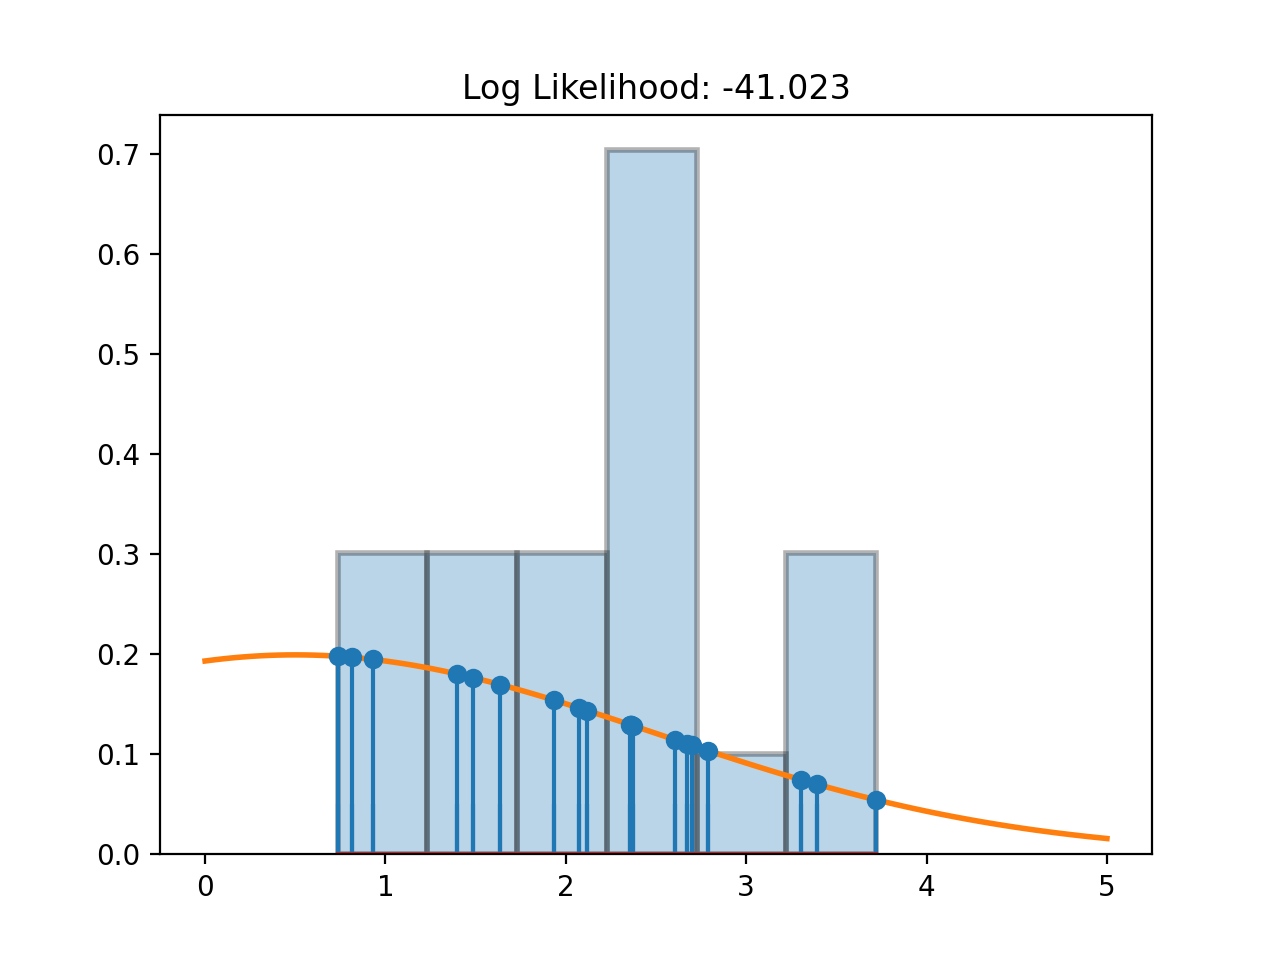

In [45]:
# let's start by visulizing our data
plt.hist(data, bins='auto', alpha=.3, lw=2, edgecolor='k', density=True);
plt.vlines(data, ymin=0, ymax=0.05)

# adjust the mean (mu) and standard deviation (sigma) to maximize the log likelihood
mu = 0.5
sigma = 2.0
xvals = np.linspace(0, 5, 100)
d = dists.norm(loc=mu, scale=sigma)
plt.plot(xvals, d.pdf(xvals), lw=2)
plt.stem(data, d.pdf(data))
plt.title('Log Likelihood: %.3f' % np.log(d.pdf(data)).sum())

## Maximum Likelihood

We can calculate parameters that maximize the likelihood of observing the data given the model and those parameters:

$$\hat{L} = P(D \mid \hat{\theta}, M)$$

However, this approach ignores the fact that there are many parameter values that *could* have generated the same data.


## Bayesian Inference

Instead, what we'd really like to know is the full set of possible parameters given the data:

$$P(\theta \mid D)$$

This should look familiar and a probability reminder should give a hint for how to calculate it...

## Basics of Probability



### A   
$P(A) \in [0, 1]$

### not A
$1 - P(A)$

### A or B 
$P(A \cup B) = P(A) + P(B) - P(A \cap B)$ or <br> $P(A \cup B) = P(A) + P(B)$ if A and B are mutually exclusive

### A and B
$P(A \cap B) = P(A \mid B) P(B) = P(B \mid A) P(A)$ or <br> $P(A \cap B) = P(A) P(B)$ if A and B are independent

### A given B 
$P(A \mid B) = \frac{P(A \cap B)}{P(B)} = \frac{P(B \mid A) P(A)}{P(B)}$






## Bayes Rule

$$P(\theta \mid D) = \frac{P(\theta \cap D)}{P(D)} = \frac{P(D \mid \theta) P(\theta)}{P(D)} \propto P(D \mid \theta) P(\theta)$$

- $P(\theta \mid D)$ is the posterior probability
- $P(D \mid \theta)$ is the likelihood
- $P(\theta)$ is the prior probability
- $P(D)$ is the marginal likelihood (*does not depend on model or params*)

## What's a prior?

A prior probability represents the initial belief in the potential values of some quantity before any new evidence is taken into account.

The notion of a prior is one of the key differences between Bayesian and Frequentist approaches. Bayesians believe that we should take such prior knowledge into account when making decisions and that this prior knowledge can be updated with each new bit of evidence:

"Today's posterior is tomorrow's prior"

That said, priors are also a major critique of Bayesian approaches because they can have a massive effect on the posterior (i.e., the conclusions you draw).

## Bayesian Inference

Determining $P(\theta \mid D)$ can be difficult for a number of reasons:

- The likelihood $P(D \mid \theta)$ is often intractable, requiring simulation
- Can be unfeasible/impossible to determine the marginal likelihood ($P(D)$)

The standard approach is to use Markov chain Monte Carlo (MCMC) to estimate the posterior.


# Bayesian Mixed-effects Regression

- We can use hierarchical Bayesian approaches to build regression models that predict trial-level data taking   into account both subject-level and item-level variability.

- The *BAyesian Model-Building Interface ([Bambi](https://bambinos.github.io/bambi/index.html))* package helps us build and perform parameter inference on mixed-effects models.


## Treating valence as continuous

/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.


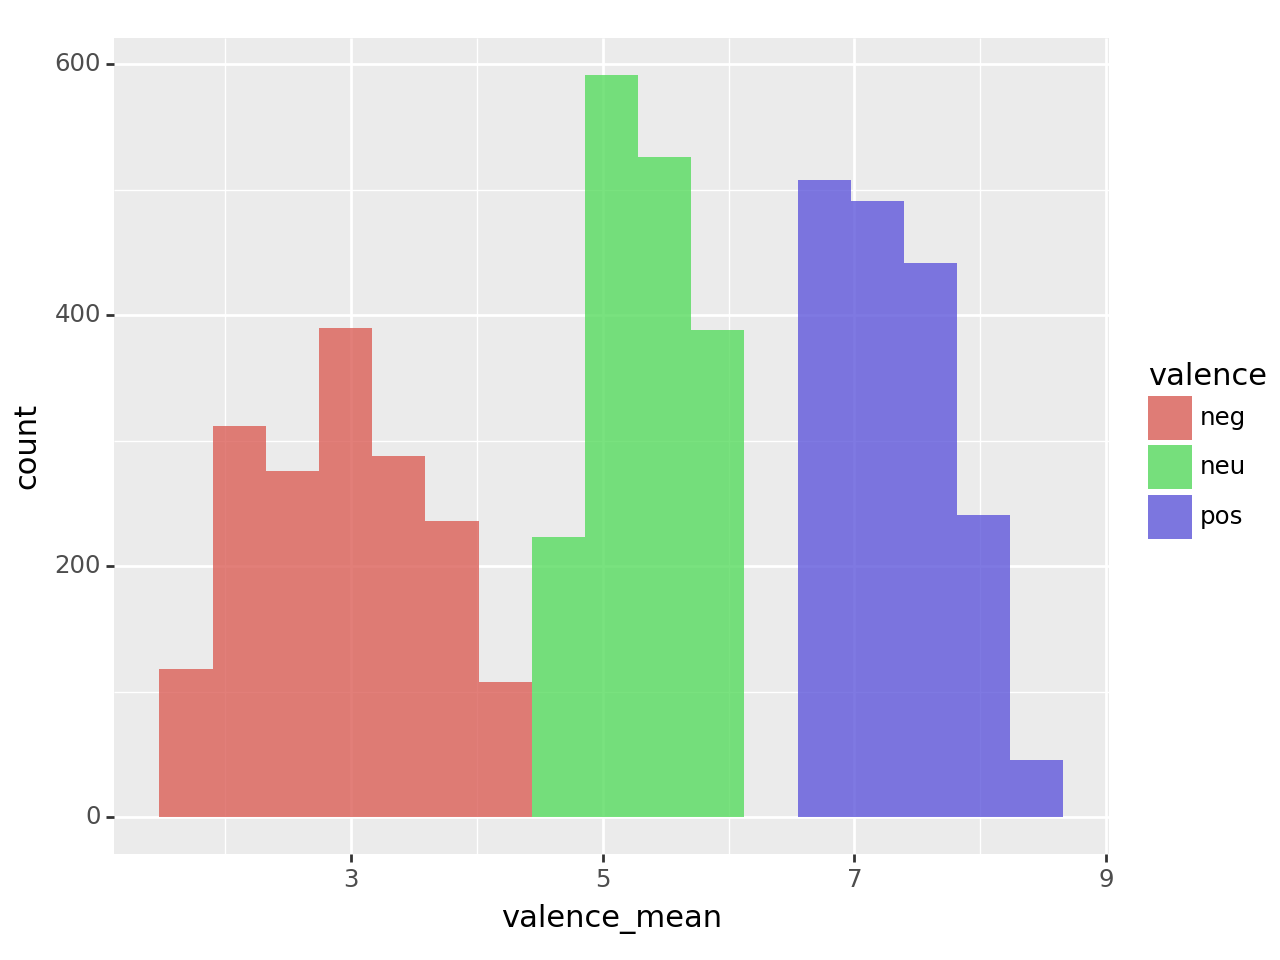

<Figure Size: (640 x 480)>

In [12]:
# Show the distributions of valence values
p = (pn.ggplot(df_t, pn.aes('valence_mean', fill='valence'))
     + pn.geom_histogram(alpha=.8)
    )
p

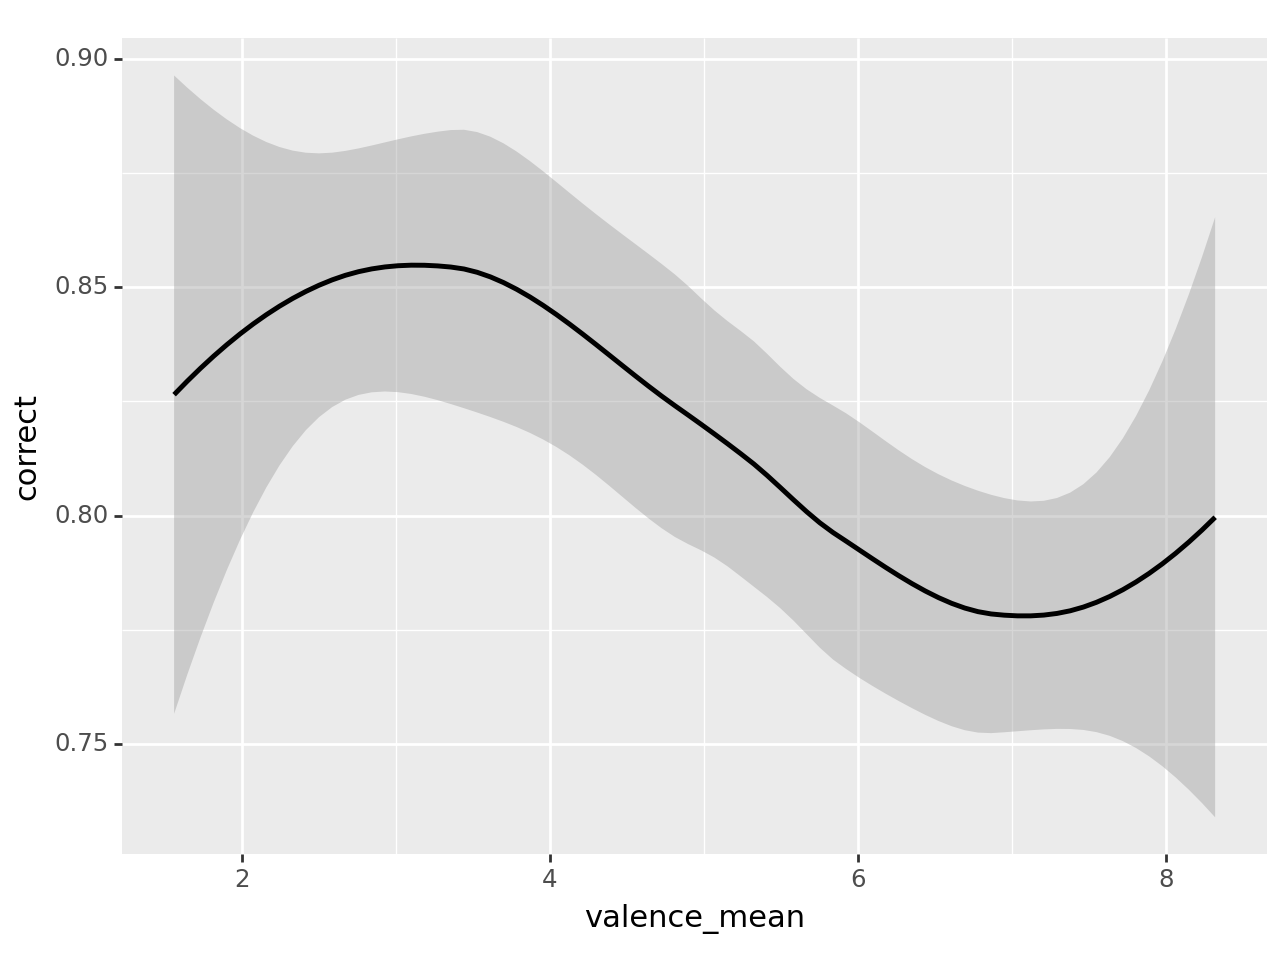

<Figure Size: (640 x 480)>

In [13]:
p = (pn.ggplot(df_t.loc[df_t['type']=='target'], pn.aes('valence_mean', 'correct'))
     + pn.geom_smooth(method='loess')
    )
p

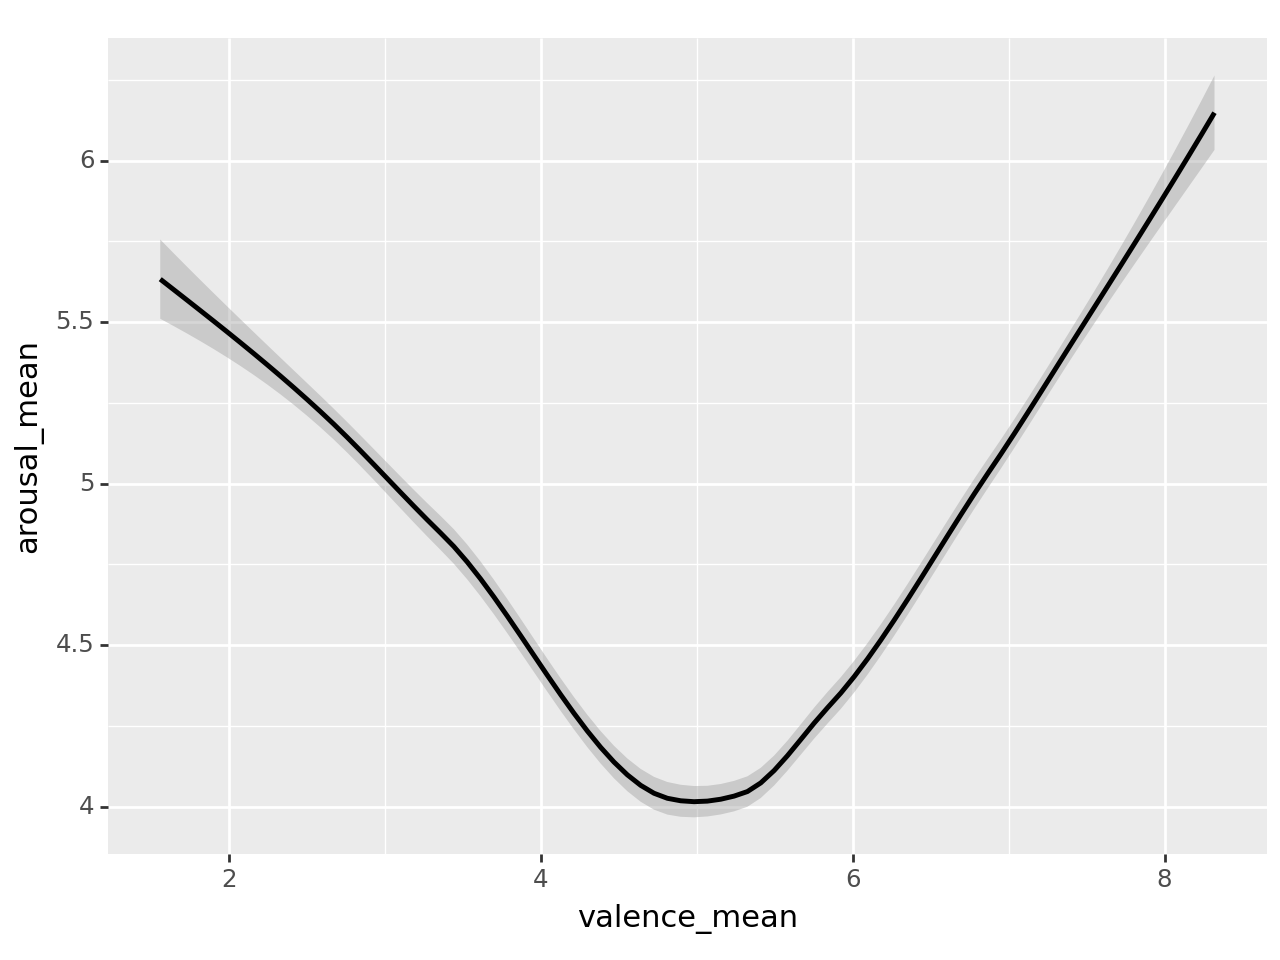

<Figure Size: (640 x 480)>

In [40]:
p = (pn.ggplot(df_t.loc[df_t['type']=='target'], pn.aes('valence_mean', 'arousal_mean'))
     + pn.geom_smooth(method='loess')
    )
p

## Build and fit the model

In [28]:
# First initialize the model with the data frame we're using
model = bmb.Model('correct ~ cond * valence_mean + (1|subj) + (1|description)', 
                  df_t.loc[df_t['type']=='target'],
                  family='bernoulli')

# next build the regression with both fixed and random effects
results = model.fit(idata_kwargs=dict(log_likelihood=True))

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, cond, valence_mean, cond:valence_mean, 1|subj_sigma, 1|subj_offset, 1|description_sigma, 1|description_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 193 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


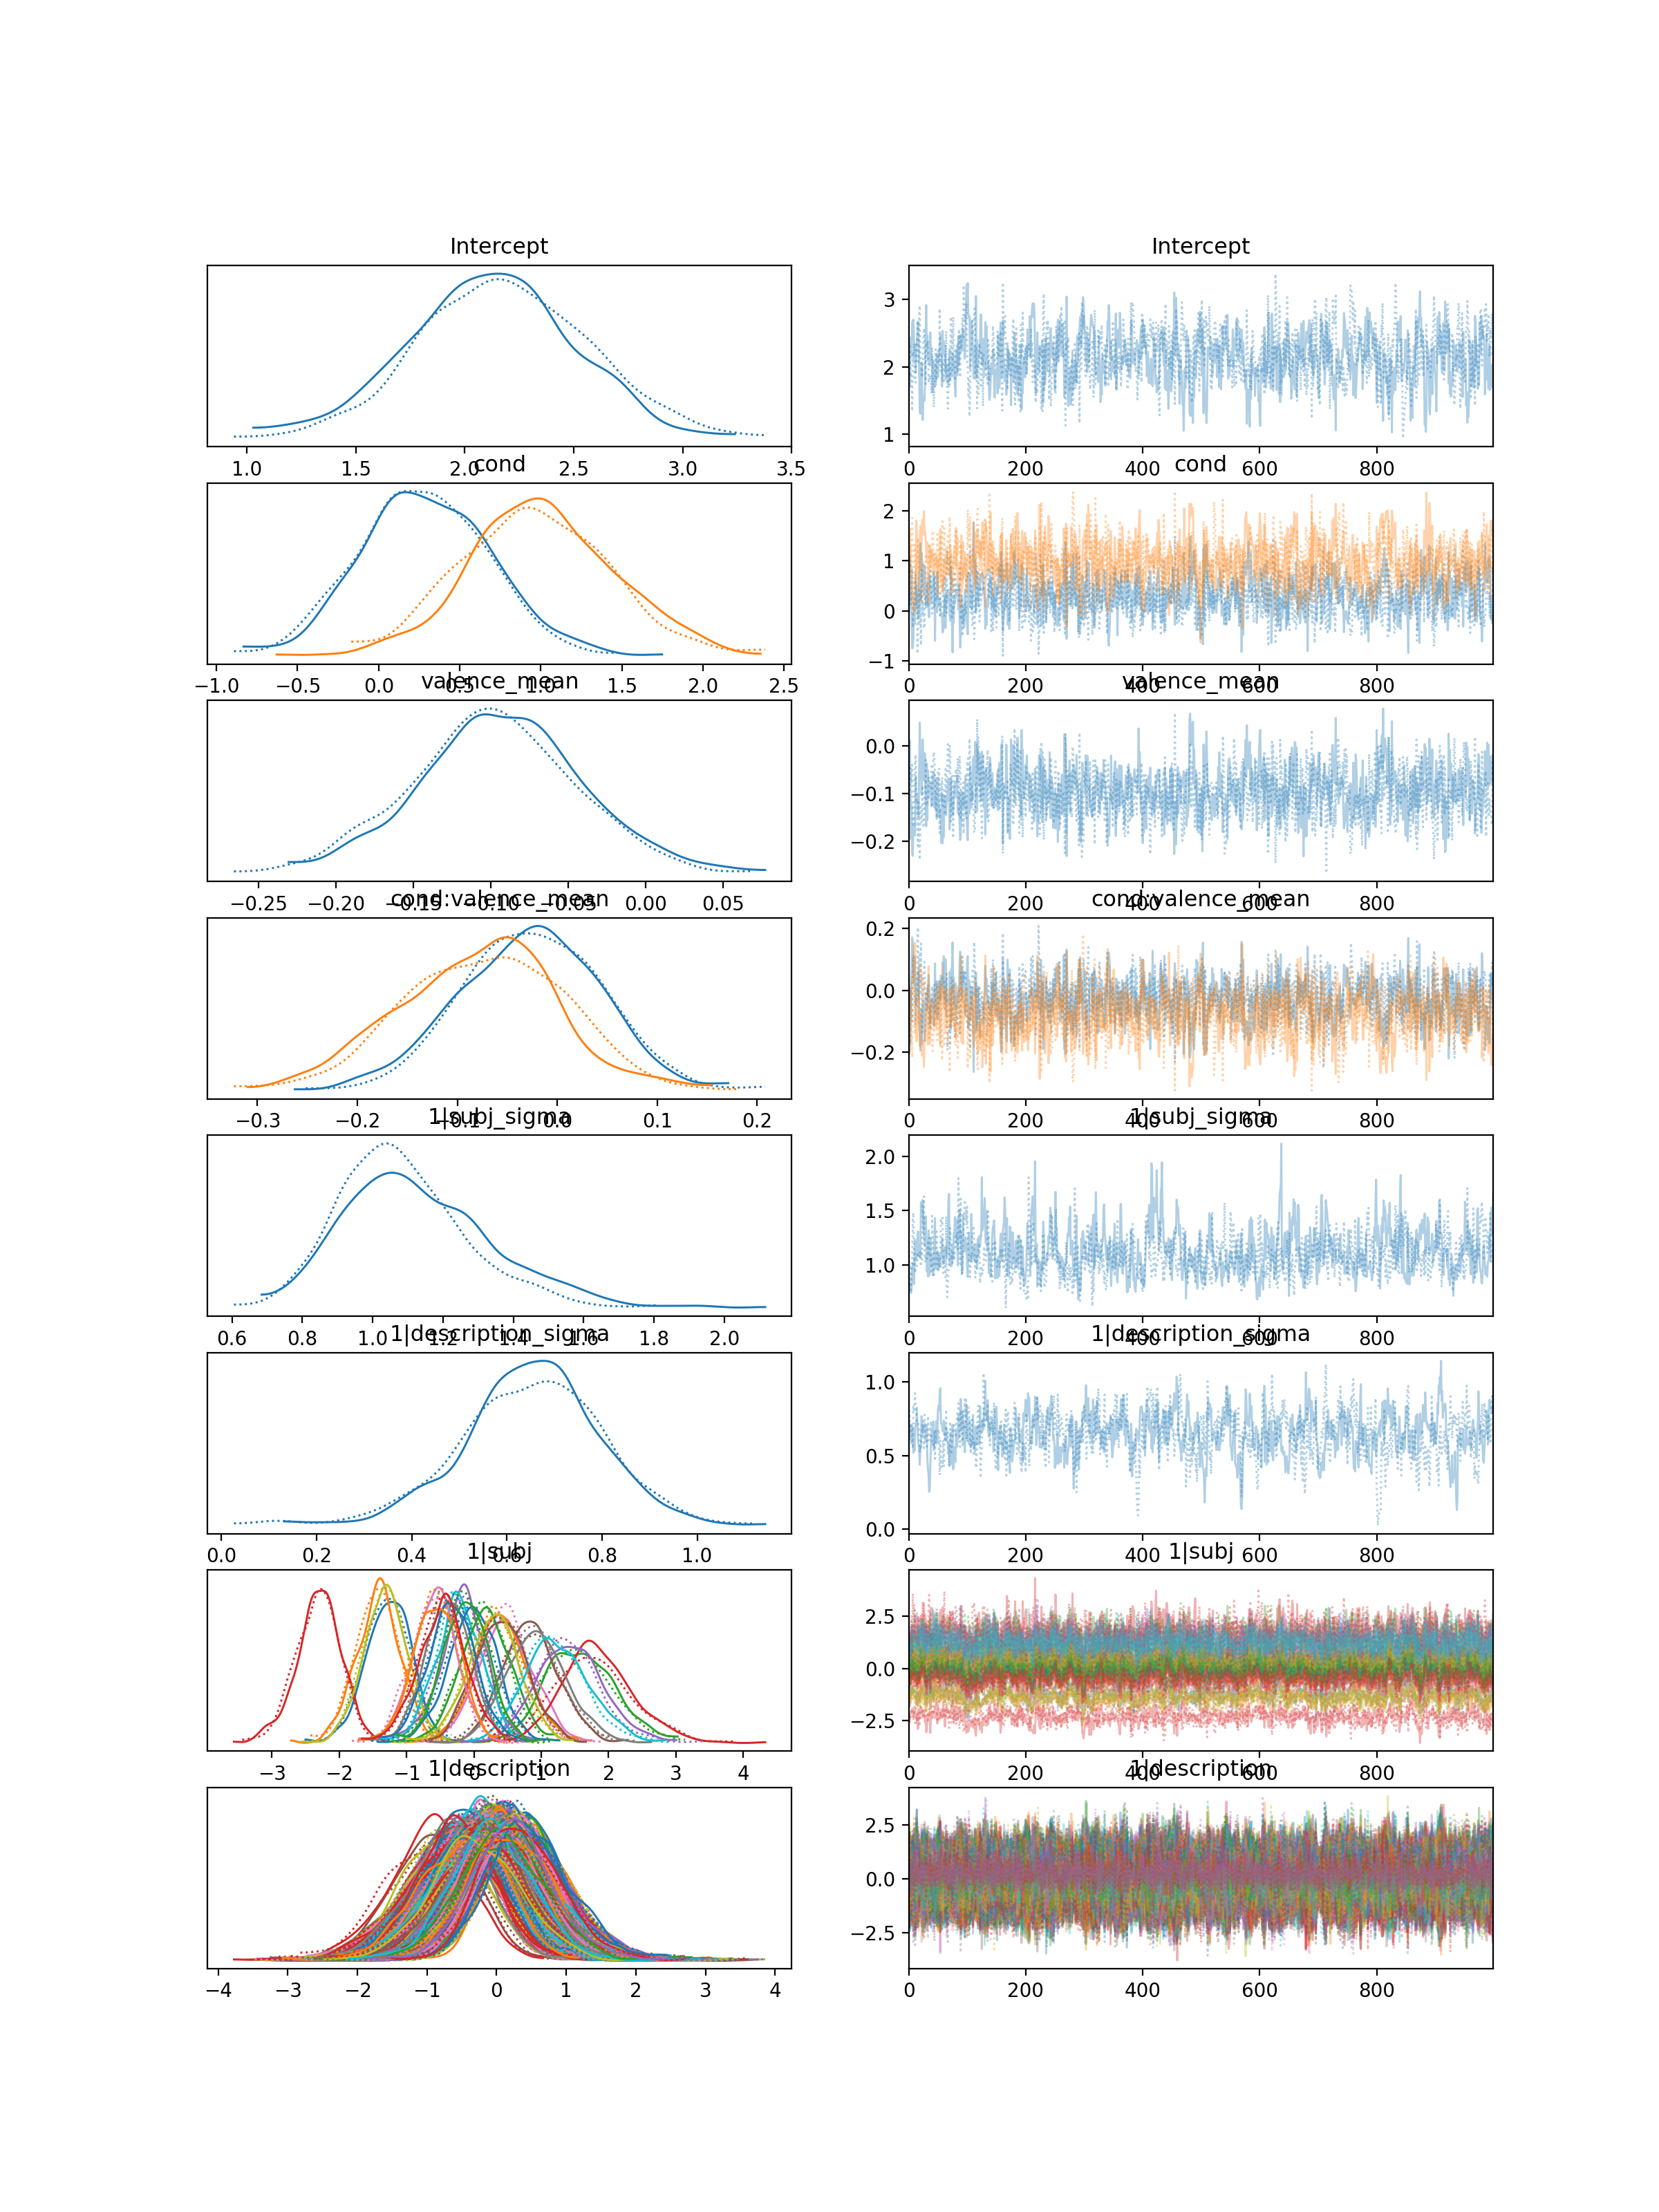

In [29]:
# plot the inference traces for the fit
az.plot_trace(results, compact=True);

In [30]:
az.summary(results)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                   2.149  0.383   1.417    2.866      0.017    0.012   
cond[refresh]               0.284  0.393  -0.416    1.033      0.014    0.010   
cond[repeat]                0.985  0.448   0.125    1.814      0.017    0.012   
valence_mean               -0.096  0.052  -0.194    0.002      0.002    0.001   
cond:valence_mean[refresh] -0.027  0.069  -0.150    0.108      0.002    0.002   
...                           ...    ...     ...      ...        ...      ...   
1|description[yacht]        0.481  0.607  -0.596    1.665      0.016    0.013   
1|description[yellow]       0.183  0.615  -1.026    1.287      0.012    0.015   
1|description[young]        0.063  0.596  -1.093    1.150      0.012    0.014   
1|description[youth]        0.352  0.584  -0.648    1.521      0.014    0.012   
1|description[zest]         0.219  0.612  -0.858    1.446      0.013    0.013   

                            ess_bulk  ess_tail  r_hat  
Intercept                      503.0     874.0   1.01  
cond[refresh]                  805.0    1052.0   1.00  
cond[repeat]                   721.0     942.0   1.00  
valence_mean                   711.0     826.0   1.00  
cond:valence_mean[refresh]     842.0     944.0   1.00  
...                              ...       ...    ...  
1|description[yacht]          1486.0    1424.0   1.00  
1|description[yellow]         2550.0    1421.0   1.00  
1|description[young]          2633.0    1357.0   1.00  
1|description[youth]          1812.0    1398.0   1.00  
1|description[zest]           2144.0    1226.0   1.00  

[807 rows x 9 columns]

## Significance involves evaluating the posteriors

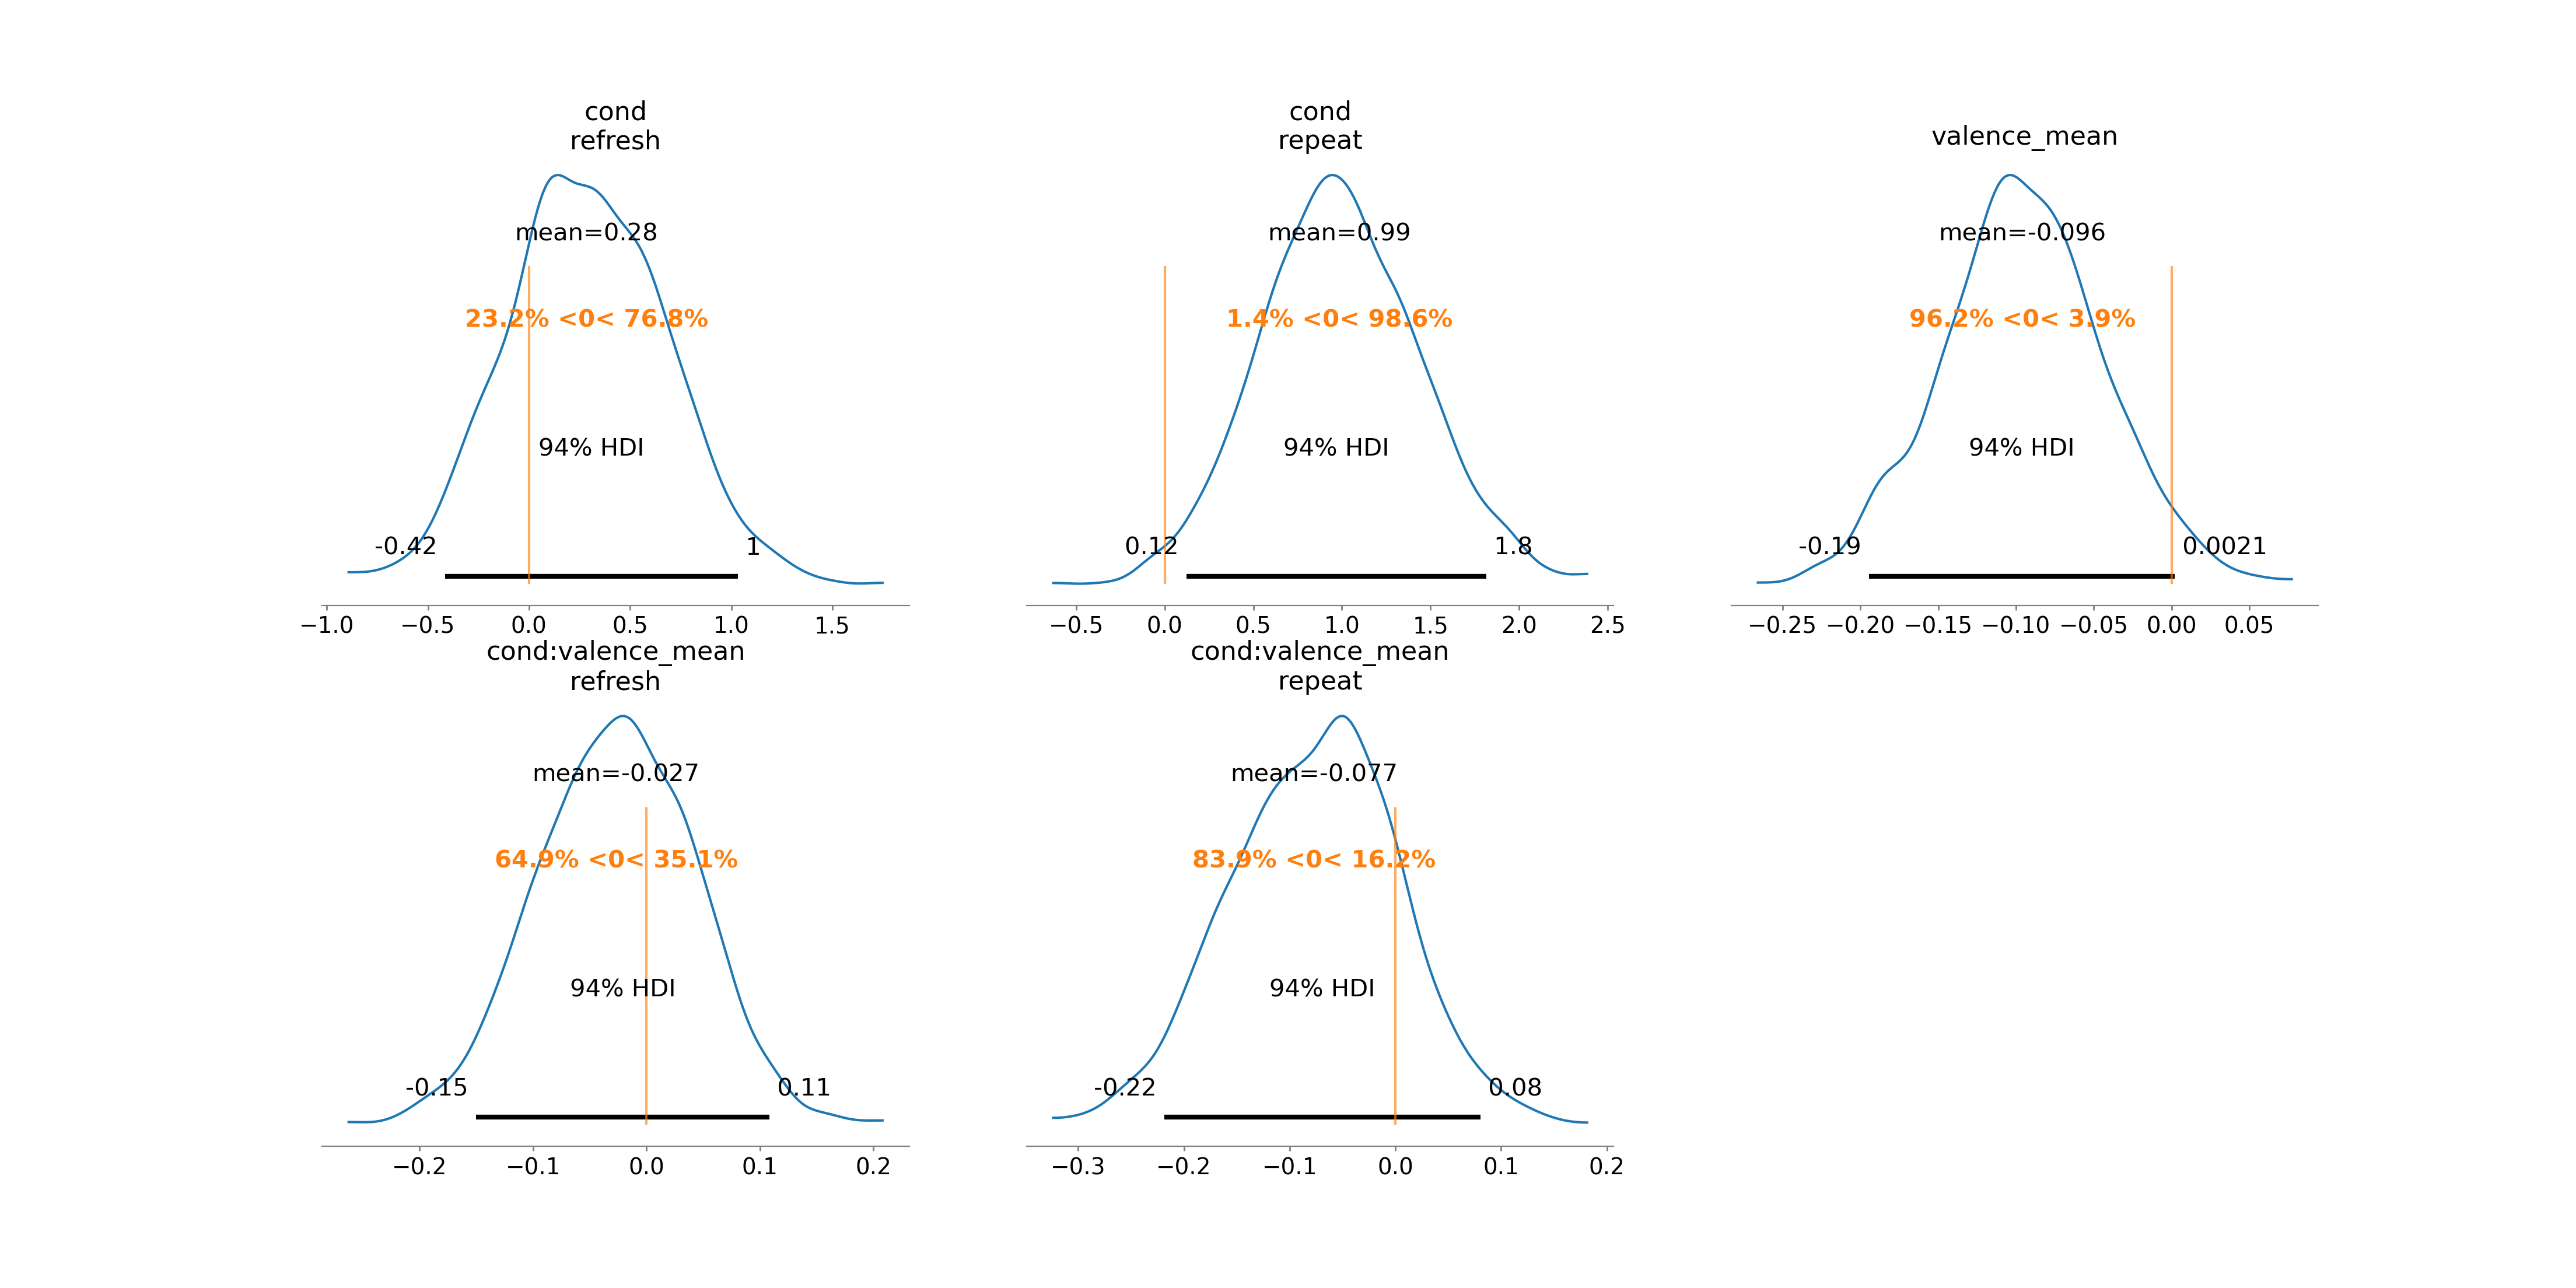

In [31]:
# plot the fixed effect posteriors to examine significance
az.plot_posterior(results, ref_val=0.0, var_names=['cond', 'valence_mean', 'cond:valence_mean']);

## Perform model comparison to determine what parameters to keep

- Not all the parameters of the model help with the fit
- We can perform Bayesian model comparison to identify the simplest model that best captures the data

In [32]:
# next build the regression without the item random effect
res_noitem = bmb.Model('correct ~ cond * valence_mean + (1|subj)', 
                  df_t.loc[df_t['type']=='target'],
                  family='bernoulli').fit(idata_kwargs=dict(log_likelihood=True))

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, cond, valence_mean, cond:valence_mean, 1|subj_sigma, 1|subj_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 103 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [33]:
# next build the regression without the interaction
res_nointer = bmb.Model('correct ~ cond + valence_mean + (1|subj)', 
                  df_t.loc[df_t['type']=='target'],
                  family='bernoulli').fit(idata_kwargs=dict(log_likelihood=True))

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, cond, valence_mean, 1|subj_sigma, 1|subj_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [34]:
# next build the regression with only valence
res_valence = bmb.Model('correct ~ valence_mean + (1|subj)', 
                  df_t.loc[df_t['type']=='target'],
                  family='bernoulli').fit(idata_kwargs=dict(log_likelihood=True))

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, valence_mean, 1|subj_sigma, 1|subj_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [35]:
# next build the regression with only cond
res_cond = bmb.Model('correct ~ cond + (1|subj)', 
                  df_t.loc[df_t['type']=='target'],
                  family='bernoulli').fit(idata_kwargs=dict(log_likelihood=True))

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, cond, 1|subj_sigma, 1|subj_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Compare the models

- The model with the fewest parameters that is not significantly worse than the other models is the best to keep.

In [36]:
cres = az.compare({'full':results, 'noitem': res_noitem, 
                   'noint':res_nointer, 'cond': res_cond, 'valence': res_valence})
cres

/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


rank     elpd_loo       p_loo  elpd_diff        weight         se  \
full        0 -1092.836412  134.911224   0.000000  7.188265e-01  29.705233   
noint       1 -1097.136717   25.067159   4.300306  7.004568e-02  29.713691   
noitem      2 -1098.497936   27.018861   5.661524  1.211431e-15  29.788937   
valence     3 -1102.512309   22.530167   9.675897  1.147994e-01  29.756983   
cond        4 -1103.592625   23.801083  10.756213  9.632841e-02  29.697019   

              dse  warning scale  
full     0.000000    False   log  
noint    4.399134    False   log  
noitem   4.295416    False   log  
valence  5.744584    False   log  
cond     5.961183    False   log

/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

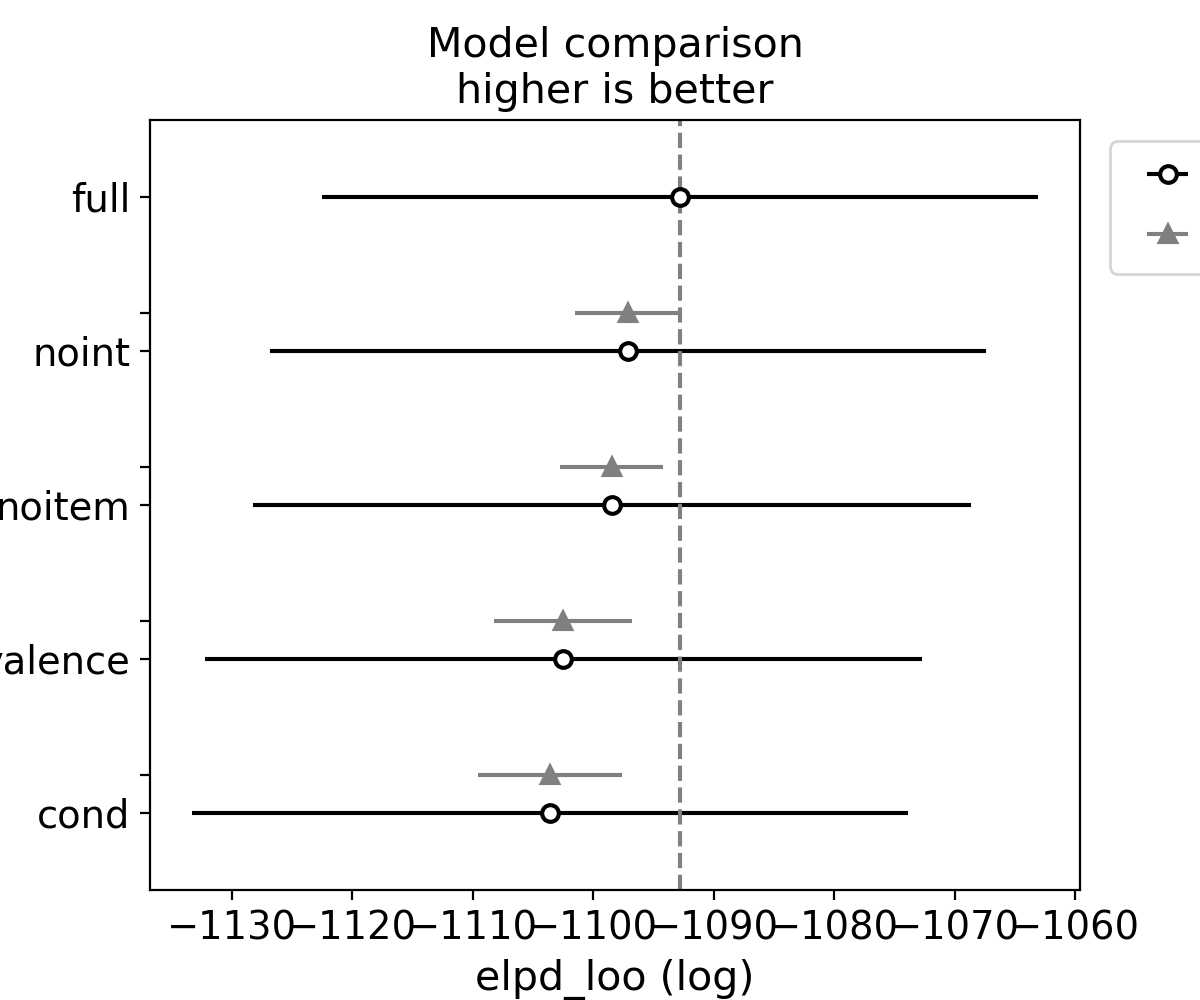

In [37]:
az.plot_compare(cres, insample_dev=False)

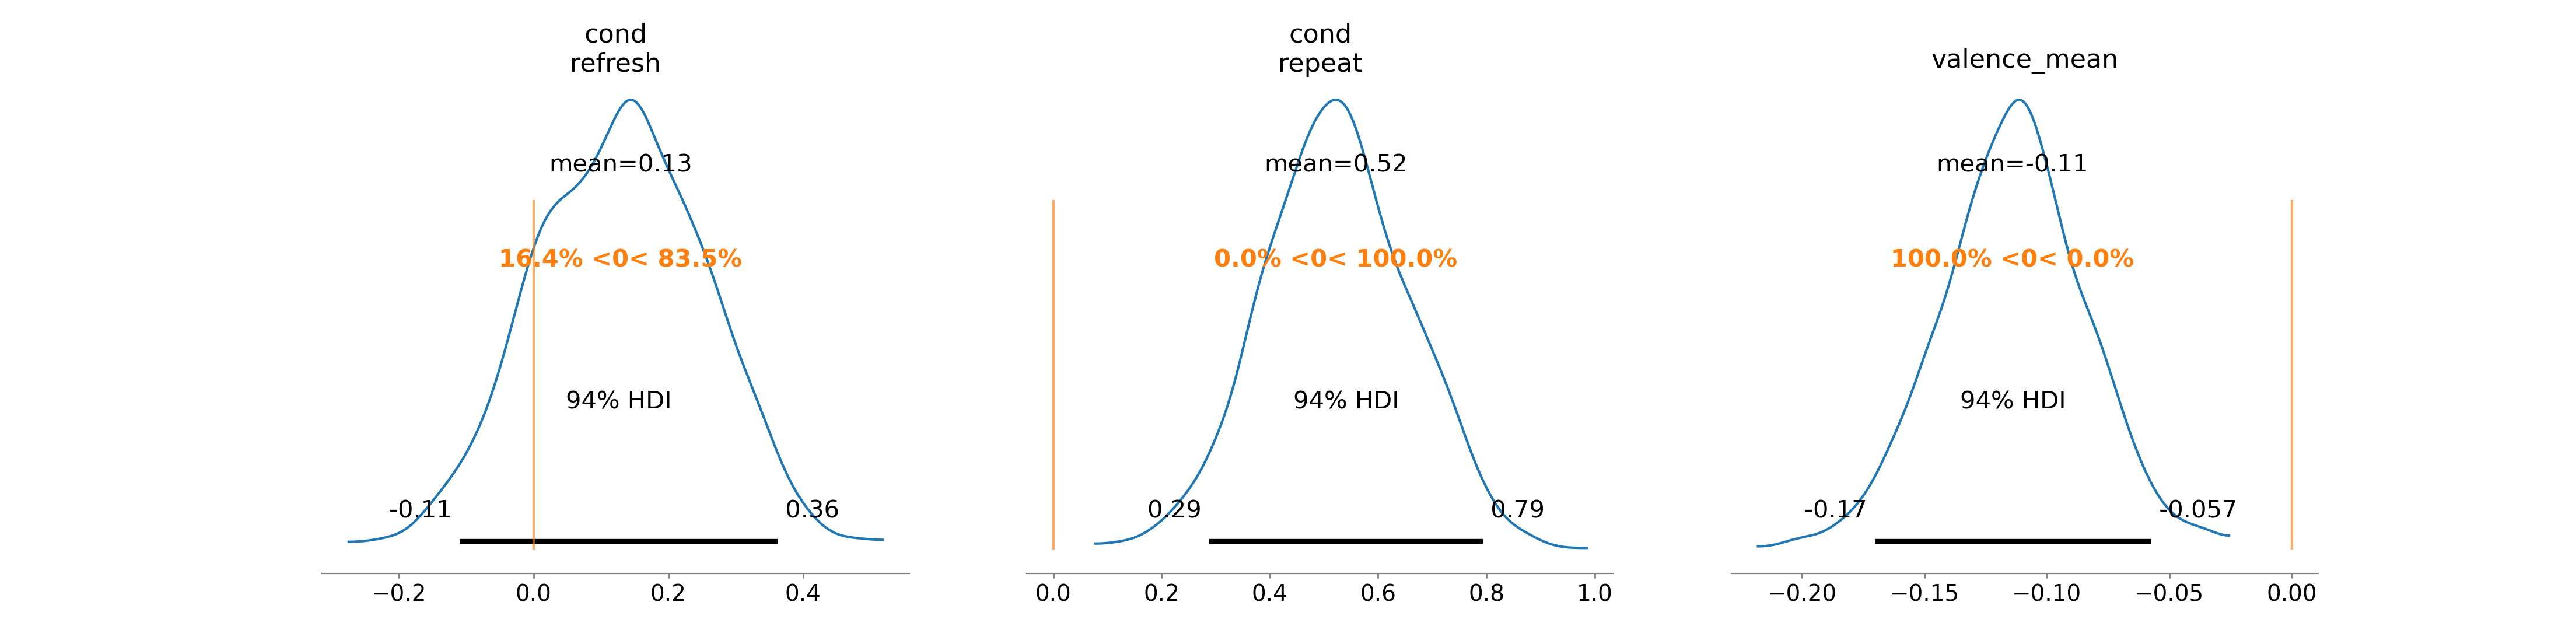

In [38]:
# show how evaluating the incorrect model can affect results
az.plot_posterior(res_nointer, ref_val=0.0, var_names=['cond', 'valence_mean']);

## Conclusion

- There seem to be effects of both condition and valence value on whether or not participants got targets correct.
- Many more analyses to do!!!

# Assignments for this week

- Please submit your Refresh data analysis by Sunday night
- Please also upload your Spacing experiment data by tomorrow
- We will post an initial spacing analysis based on these data
